# Clasificador Naive Bayes de noticias argentinas

<a target="_blank" href="https://colab.research.google.com/github/pdomins/bayesian-learning/blob/master/ej2_bayes_news.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

El objetivo de este ejercicio es implementar un clasificador de texto utilizando el **clasificador ingenuo de Bayes** sobre el
conjunto de datos *”Noticias Argentinas”* para clasificar cada noticia según su tipo.

Instalaciones previas necesarias:

In [1]:
%%capture
!python -m pip install nltk       # for stopwords
!python -m pip install spacy      # for tokenization
!python -m pip install openpyxl   # for file reading
!python -m pip install wordcloud  # for wordclouds
!python -m spacy download es_core_news_md   # for lemmatization
!python -m pip install scikit-learn         # for integrals

Librerías utilizadas:

In [2]:
import pandas as pd

import nltk     # for stopwords
import spacy    # for tokenization and lemmatization
import re       # for regular expressions

from nltk.corpus import stopwords

## Análisis del dataset

En principio contamos con 164690 tuplas:

In [3]:
df = pd.read_csv("data/noticias_argentinas_clean_2.csv", delimiter=";")
df

,fecha,titular,fuente,categoria
0,14/11/2018 09:08,Trabajadores del Buenos Aires Design cortan la...,Infobae.com,Nacional
1,13/11/2018 14:14,La boda del gobernador Gerardo Morales: tapas ...,Clarín.com,Nacional
2,14/11/2018 10:08,Cumbre del G20: qué calles estarán cortadas y ...,iprofesional.com,Nacional
3,14/11/2018 02:02,Una fractura que confirma la candidatura de Cr...,LA NACION (Argentina.),Nacional
4,14/11/2018 09:03,Infierno grande: ola de divorcios en un pueblo...,Diario El Día,Nacional
...,...,...,...,...
164685,19/8/2019 09:13,¡Que lo vengan a Berlín!,Olé,Noticias destacadas
164686,20/8/2019 09:56,"Con datos de la NASA, identifican 10 mil millo...",LaRepública.pe,Noticias destacadas
164687,19/8/2019 16:20,3 enfermedades de transmisión sexual que puede...,La 100,Noticias destacadas
164688,19/8/2019 20:12,Hallan evidencia de que la meditación plena ay...,Clarín,Noticias destacadas


Al enumerar las categorías nos encontramos con el valor NaN, indicando que hay tuplas sin especificar su categoría:

In [4]:
df['categoria'].unique()

array(['Nacional', 'Destacadas', 'Deportes', 'Salud',
       'Ciencia y Tecnologia', 'Entretenimiento', 'Economia',
       'Internacional', nan, 'Noticias destacadas'], dtype=object)

Al contar los valores por cada una:

In [5]:
print(df.groupby('categoria')['titular'].count())

categoria
Ciencia y Tecnologia      3856
Deportes                  3856
Destacadas                3859
Economia                  3850
Entretenimiento           3850
Internacional             3850
Nacional                  3860
Noticias destacadas     133819
Salud                     3840
Name: titular, dtype: int64


Además, al observar el dataset podemos ver que existen tuplas que se encuentran repetidas. Teniendo esto en cuenta, contamos nuevamente las noticias:

In [6]:
print(df.groupby('categoria')['titular'].nunique())

categoria
Ciencia y Tecnologia      889
Deportes                 1804
Destacadas               2195
Economia                 1186
Entretenimiento          1506
Internacional            1739
Nacional                 1582
Noticias destacadas     39456
Salud                     797
Name: titular, dtype: int64


La categoría "Noticias destacadas" tiene una cantidad considerablemente mayor de titulares que el resto. Además, es una categoría general que contempla a noticias de todo tipo. En ejecuciones anteriores esto demostró un error muy grande al estimar. Como también afecta en la performance, vamos a desestimar todas las noticias que caigan dentro de esta categoría... por ahora.

In [7]:
df_filtered = pd.DataFrame(df[df['categoria'] != 'Noticias destacadas'])
df_filtered = df_filtered.drop(df_filtered[df_filtered['categoria'].isna()].index, axis="index")
print(df_filtered.groupby('categoria')['titular'].count())

categoria
Ciencia y Tecnologia    3856
Deportes                3856
Destacadas              3859
Economia                3850
Entretenimiento         3850
Internacional           3850
Nacional                3860
Salud                   3840
Name: titular, dtype: int64


In [8]:
df_filtered.shape

(30821, 4)

## Preprocesamiento de los datos

Vamos a expresar los títulos como un array conformado por sus palabras relevantes lematizadas:

In [9]:
# stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))
stop_words.add("ser")

# tokenization and lemmatization
nlp = spacy.load("es_core_news_md")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\74005\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def remove_numbers_and_symbols(input_string):
    pattern = r'[^a-zA-ZáéíóúÁÉÍÓÚñÑüÜ\s]'
    cleaned_string = re.sub(pattern, '', input_string)
    return cleaned_string

In [11]:
def preprocess_text(title_string : str):

  # removing unnecesary symbols and tokenization
  title = nlp(remove_numbers_and_symbols(title_string))

  lemmas = []

  for tok in title:
    word = tok.lemma_.lower()
    if word not in stop_words:
      lemmas.append(word)

  return lemmas

In [12]:
df_filtered['titular'] = df_filtered['titular'].apply(preprocess_text)

## Armado de vocabulario

Para empezar creamos un diccionario con todas las palabras utilizadas en los titulares para cada categoría, evitando repetidos en cada set:

In [13]:
def get_categories(df : pd.DataFrame):
    return df.dropna(subset=['categoria'])['categoria'].unique()

In [14]:
def get_vocab(df : pd.DataFrame, categories: list):

  vocab = {}

  for category in categories:

    # set of words used in the current category
    cat_vocab = set()

    # subset of training data of the current category
    cat_train_df = df[df['categoria'] == category]

    for title in cat_train_df['titular']:
      cat_vocab.update(title)

    vocab[category] = list(cat_vocab)
  
  return vocab

## Cálculo de frecuencias

Iteramos los titulares dentro de cada categoría y calculamos la frecuencia de aparición de las palabras dentro de cada categoría:

In [15]:
K_POSSIBLE_VALUES = 2; # word either appears or not

In [16]:
def get_frequencies(df : pd.DataFrame, categories : list, vocab : dict):

  vocab_freq = {}
  laplace_vocab_freq = {}
  titles_by_cat = {}

  for cat_idx, category in enumerate(categories):

    # all the words used the in current category
    word_list = vocab[categories[cat_idx]]

    # dict with the frequencies of every word in the current category
    words_freq = { key: 0 for key in word_list }
    words_laplace_freq = { key: 0 for key in word_list }

    # training data subset of the current category
    cat_train_df = df[df['categoria'] == category]

    # amount of titles in the current category
    cat_title_count = len(cat_train_df['titular'])
    titles_by_cat[category] = cat_title_count

    for word in word_list:
      for title in cat_train_df['titular']:
        if word in title:
          words_freq[word] += (1 / cat_title_count)
          words_laplace_freq[word] += (1 / (cat_title_count+K_POSSIBLE_VALUES))
      words_laplace_freq[word] += (1 / (cat_title_count+K_POSSIBLE_VALUES))

    vocab_freq[category] = words_freq
    laplace_vocab_freq[category] = words_laplace_freq

  return vocab_freq, laplace_vocab_freq, titles_by_cat

## Cálculo de probabilidades

Primero calculamos la probabilidad de que un titular pertenezca a cierta categoría:

In [17]:
def p_cat(categories : list, titles_by_cat : dict):

  title_count = sum(titles_by_cat.values())
  p_cat = { key: 0 for key in categories }

  for category in categories:
    p_cat[category] = titles_by_cat[category] / title_count

  return p_cat

Con esta información y con las frecuencias guardadas en la sección anterior podemos calcular **P(A|categoria)**, es decir, la probabilidad de ocurrencia de un conjunto de palabras dada cierta categoría:

In [18]:
def p_a_cat(conj_a : list, cat_vocab_freq : dict):
  prob = 1
  for word in conj_a:
    prob *= cat_vocab_freq.get(word, 0)
  return prob

In [19]:
def p_a_cat_laplace(conj_a : list, cat_laplace_vocab_freq : dict, total_titles_cat : int):
  prob = 1
  for word in conj_a:
    freq = cat_laplace_vocab_freq.get(word, 0)
    if freq > 0:
      prob *= freq
    else:
      prob *= (1 / (total_titles_cat+K_POSSIBLE_VALUES))
  return prob

Luego obtenemos **P(A)**, la probabilidad de ocurrencia de un conjunto de palabras:

In [20]:
def p_a(conj_a : list, categories : list, prob_cats : dict, vocab_freq : dict, titles_by_cat : dict, laplace_smoothing : bool = False, laplace_vocab_freq : dict = None):
  prob = 0
  for category in categories:
    prob_a_cat = 0
    if laplace_smoothing:
      prob_a_cat = p_a_cat_laplace(conj_a, laplace_vocab_freq[category], titles_by_cat[category])
    else:
      prob_a_cat = p_a_cat(conj_a, vocab_freq[category])
    prob += (prob_a_cat * prob_cats[category])
  return prob

Finalmente podemos calcular **P(categoria|A)**, la probabilidad de que un titular pertenezca a cierta categoría dado su conjunto de palabras:

In [21]:
def p_cat_a(prob_a_cat : float, prob_cat : float, prob_a : float):
    return prob_a_cat * prob_cat / prob_a

## Naive Bayes

Calculamos las probabilidades P(categoria|A) para cada categoría y nos quedamos con la de mayor valor:

In [22]:
def naive_bayes(conj_a : list, categories : list, vocab_freq : dict, titles_by_cat : dict, prob_cats : dict, laplace_smoothing : bool = False, laplace_vocab_freq : dict = None):

  p_cats_a = {}
  prob_a = p_a(conj_a, categories, prob_cats, vocab_freq, titles_by_cat, laplace_smoothing, laplace_vocab_freq)

  for category in categories:

    prob_a_cat = 0
    if laplace_smoothing:
      prob_a_cat = p_a_cat_laplace(conj_a, laplace_vocab_freq[category], titles_by_cat[category])
    else:
      prob_a_cat = p_a_cat(conj_a, vocab_freq[category])

    p_cats_a[category] = p_cat_a(prob_a_cat, prob_cats[category], prob_a)
  
  return max(p_cats_a, key = lambda k: p_cats_a[k]), p_cats_a, prob_a

## Probando el clasificador

Utilizamos el método K-Fold para futura cross-validation:

In [23]:
from data_split import k_fold_split

Vamos a crear dos conjuntos, uno de entrenamiento y otro de testeo, por lo que nos queda:

In [24]:
k = 2

test_size = df_filtered.shape[0] / k
(test_size * (k-1), test_size)

(15410.5, 15410.5)

In [25]:
train_df, test_df = k_fold_split(df_filtered, k)

In [26]:
def train(df : pd.DataFrame, possible_labels: list):
    vocab = get_vocab(df, possible_labels)
    vocab_freq, laplace_vocab_freq, titles_by_cat = get_frequencies(df, possible_labels, vocab)
    prob_cats = p_cat(possible_labels, titles_by_cat)
    return {
        "possible_labels": possible_labels,
        "vocab": vocab,
        "vocab_freq": vocab_freq,
        "laplace_vocab_freq": laplace_vocab_freq,
        "titles_by_cat": titles_by_cat,
        "prob_cats": prob_cats
    }

In [27]:
possible_labels = get_categories(df_filtered)
trained_params = train(train_df, possible_labels)
selected_class, p_cats_a, prob_conj_a = naive_bayes(["messi", "pelota"], possible_labels, trained_params["vocab_freq"], trained_params["titles_by_cat"], trained_params["prob_cats"], True, trained_params["laplace_vocab_freq"])

for category in p_cats_a.keys():
    print(f"P ( cat = '{category}' | A ) = {p_cats_a[category]}")

print(f"\nSelected class: {selected_class}")

P ( cat = 'Nacional' | A ) = 0.044681412483346096
P ( cat = 'Destacadas' | A ) = 0.015141517627028984
P ( cat = 'Deportes' | A ) = 0.8945429133030236
P ( cat = 'Salud' | A ) = 0.007547222826537658
P ( cat = 'Ciencia y Tecnologia' | A ) = 0.007727394852568241
P ( cat = 'Entretenimiento' | A ) = 0.015446595243404877
P ( cat = 'Economia' | A ) = 0.007473648209156216
P ( cat = 'Internacional' | A ) = 0.007439295454934379

Selected class: Deportes


In [68]:
p_cats_a

{'Nacional': 0.044681412483346096,
 'Destacadas': 0.015141517627028984,
 'Deportes': 0.8945429133030236,
 'Salud': 0.007547222826537658,
 'Ciencia y Tecnologia': 0.007727394852568241,
 'Entretenimiento': 0.015446595243404877,
 'Economia': 0.007473648209156216,
 'Internacional': 0.007439295454934379}

## Wordcloud

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [29]:
def get_wordcloud(category : str, d : dict):
    wordcloud = WordCloud(width = 1000, height = 800, background_color ='white', stopwords = stop_words)
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

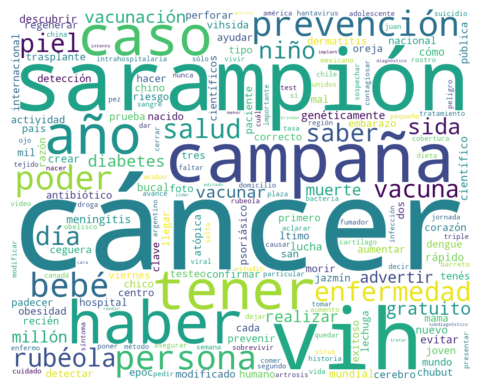

In [30]:
cate = 'Salud'
get_wordcloud(cate, trained_params['vocab_freq'][cate])

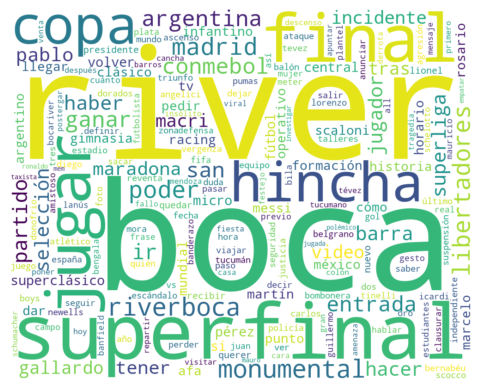

In [31]:
cate = 'Deportes'
get_wordcloud(cate, trained_params['vocab_freq'][cate])

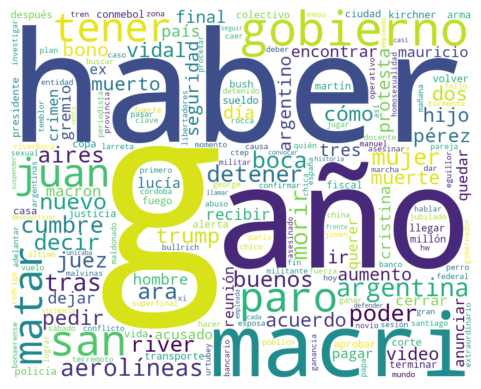

In [32]:
cate = 'Destacadas'
get_wordcloud(cate, trained_params['vocab_freq'][cate])

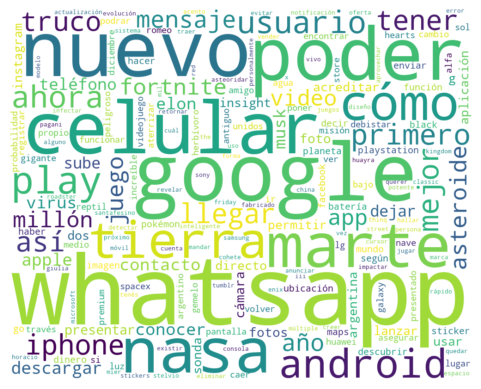

In [33]:
cate = 'Ciencia y Tecnologia'
get_wordcloud(cate, trained_params['vocab_freq'][cate])

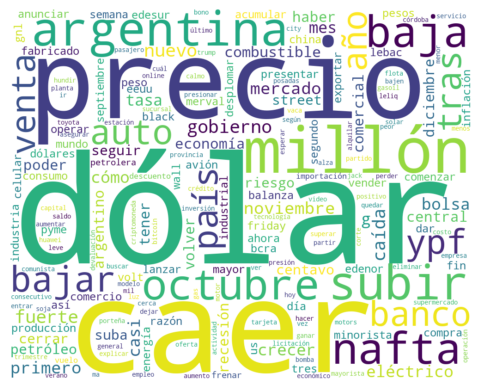

In [34]:
cate = 'Economia'
get_wordcloud(cate, trained_params['vocab_freq'][cate])

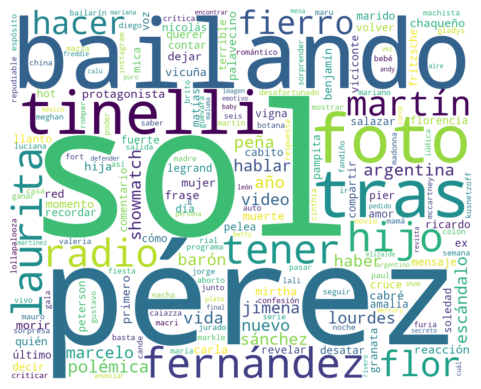

In [35]:
cate = 'Entretenimiento'
get_wordcloud(cate, trained_params['vocab_freq'][cate])

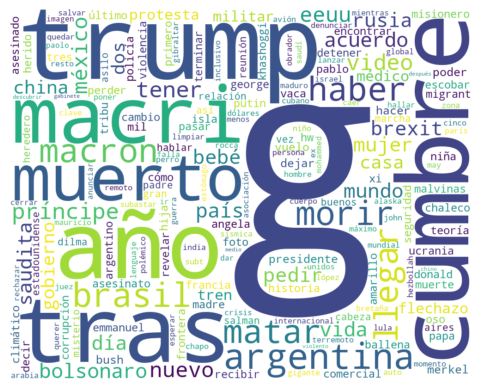

In [36]:
cate = 'Internacional'
get_wordcloud(cate, trained_params['vocab_freq'][cate])

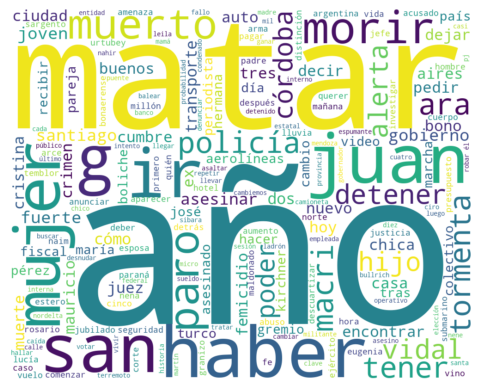

In [37]:
cate = 'Nacional'
get_wordcloud(cate, trained_params['vocab_freq'][cate])

## Error de clasificación

In [38]:
def predict(test_serie : pd.Series, trained_params : dict):
    selected_class, _, _ = naive_bayes(test_serie['titular'], trained_params["possible_labels"], trained_params["vocab_freq"], trained_params["titles_by_cat"], trained_params["prob_cats"], True, trained_params["laplace_vocab_freq"])
    return selected_class

In [69]:
# def predict_with_dict(test_serie : pd.Series, trained_params : dict, category : str):
#     selected_class, prob_cats_a = naive_bayes(test_serie['titular'], trained_params["possible_labels"], trained_params["vocab_freq"], trained_params["titles_by_cat"], trained_params["prob_cats"], True, trained_params["laplace_vocab_freq"])
#     pred_prob_cat = prob_cats_a[category]
#     prediction_prob = {'N': , 'P': pred_prob_cat}
#     return selected_class, prediction_prob

Cross-validation:

In [40]:
from error_functions import compute_classification_error
from df_utils        import get_column_value_dict

In [41]:
test_df_label_dict = get_column_value_dict(test_df, "categoria")
error_cases = compute_classification_error(test_df, test_df_label_dict, predict, trained_params)
total_cases = test_df.shape[0]

In [42]:
print(f"Error en {error_cases} de {total_cases} titulares ({round(error_cases/total_cases*100, 2)}%)")

Error en 2701 de 15411 titulares (17.53%)


## División óptima del conjunto de textos

In [43]:
from error_functions import k_fold_cross_validation

In [44]:
k_splits = k_fold_cross_validation(df_filtered, possible_labels, "categoria", train, predict, 5)

In [45]:
i = 1
for k_split in k_splits:
    print(f"Split #{i}")
    train_set = k_split["train"]
    test_set  = k_split["test"]
    print(f"Error training: {train_set['err']}")
    print(f"Error test: {test_set['err']}")
    print("\n------------------------------------------------\n")
    i += 1

Split #1
Error training: 2948
Error test: 1065

------------------------------------------------

Split #2
Error training: 3004
Error test: 989

------------------------------------------------

Split #3
Error training: 3029
Error test: 1002

------------------------------------------------

Split #4
Error training: 3016
Error test: 1067

------------------------------------------------

Split #5
Error training: 3036
Error test: 978

------------------------------------------------



## Confusion matrix

In [46]:
from confusion_matrix import calculate_confusion_matrix, \
                             calculate_roc_confusion_matrices, \
                             calculate_roc_positive_rates
import numpy as np

In [70]:
predicted = dict()
for sample_idx, sample in test_df.drop("categoria", axis="columns").iterrows():
    predicted[sample_idx] = predict(sample, trained_params)

In [72]:
conf_mat = calculate_confusion_matrix(possible_labels, predicted, test_df_label_dict)

In [73]:
from plotter import plot_confusion_matrix

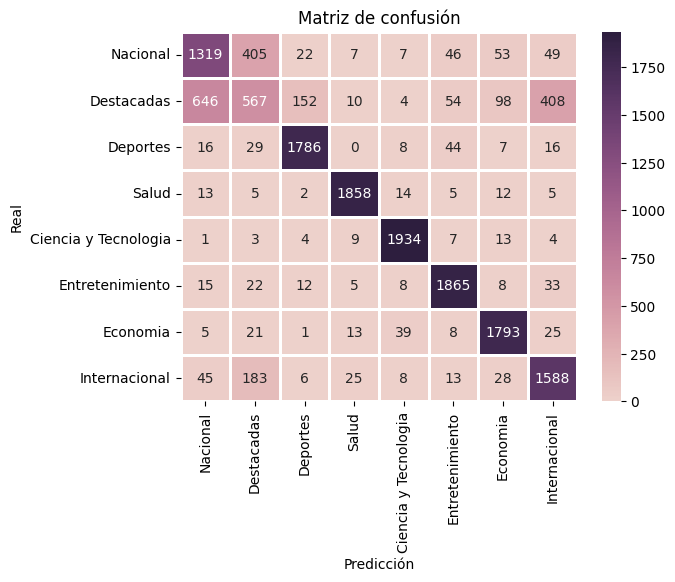

In [61]:
plot_confusion_matrix(conf_mat, "Matriz de confusión", "conf_mat.png", ".0f")

## Metrics

In [54]:
from confusion_matrix import calculate_per_label_confusion_matrix, metrics

In [65]:
per_label_conf_mats = calculate_per_label_confusion_matrix(possible_labels, predicted, test_df_label_dict)
per_label_metrics = metrics(per_label_conf_mats)

In [66]:
for label in per_label_metrics.keys():
    print("Metrics for label \"" + str(label) + "\"")
    display(per_label_metrics[label])

Metrics for label "Nacional"


{'TP': 1319.0,
 'FP': 741.0,
 'FN': 589.0,
 'TN': 12762.0,
 'Precision': 0.6402912621359224,
 'Recall': 0.6912997903563941,
 'F1 Score': 0.6648185483870968,
 'Accuracy': 0.9136980079164233}

Metrics for label "Destacadas"


{'TP': 567.0,
 'FP': 668.0,
 'FN': 1372.0,
 'TN': 12804.0,
 'Precision': 0.4591093117408907,
 'Recall': 0.2924187725631769,
 'F1 Score': 0.3572778827977316,
 'Accuracy': 0.8676270196612809}

Metrics for label "Deportes"


{'TP': 1786.0,
 'FP': 199.0,
 'FN': 120.0,
 'TN': 13306.0,
 'Precision': 0.8997481108312343,
 'Recall': 0.9370409233997902,
 'F1 Score': 0.9180159342071447,
 'Accuracy': 0.979300499643112}

Metrics for label "Salud"


{'TP': 1858.0,
 'FP': 69.0,
 'FN': 56.0,
 'TN': 13428.0,
 'Precision': 0.964193046185781,
 'Recall': 0.9707419017763845,
 'F1 Score': 0.9674563915646966,
 'Accuracy': 0.9918889105184608}

Metrics for label "Ciencia y Tecnologia"


{'TP': 1934.0,
 'FP': 88.0,
 'FN': 41.0,
 'TN': 13348.0,
 'Precision': 0.9564787339268052,
 'Recall': 0.979240506329114,
 'F1 Score': 0.9677257943457593,
 'Accuracy': 0.9916293556550516}

Metrics for label "Entretenimiento"


{'TP': 1865.0,
 'FP': 177.0,
 'FN': 103.0,
 'TN': 13266.0,
 'Precision': 0.9133202742409402,
 'Recall': 0.9476626016260162,
 'F1 Score': 0.9301745635910224,
 'Accuracy': 0.9818311595613523}

Metrics for label "Economia"


{'TP': 1793.0,
 'FP': 219.0,
 'FN': 112.0,
 'TN': 13287.0,
 'Precision': 0.8911530815109344,
 'Recall': 0.9412073490813648,
 'F1 Score': 0.9154965534848098,
 'Accuracy': 0.9785218350528843}

Metrics for label "Internacional"


{'TP': 1588.0,
 'FP': 540.0,
 'FN': 308.0,
 'TN': 12975.0,
 'Precision': 0.7462406015037594,
 'Recall': 0.8375527426160337,
 'F1 Score': 0.7892644135188867,
 'Accuracy': 0.9449743689572383}

## ROC curve

In [ ]:
label_dict_p_or_f_cats = {}
for category in possible_labels:
    test_df_label_dict_p_or_f = dict()
    for key in test_df_label_dict.keys():
        test_df_label_dict_p_or_f[key] = "P" if test_df_label_dict[key] == category \
                                    else "N"
    label_dict_p_or_f_cats[category] = test_df_label_dict_p_or_f

In [ ]:
cats_prediction_probabilities = {}

for category in possible_labels:
    n_prob = (sum(p_cats_a.values()) - p_cats_a[category]) / prob_conj_a
    cats_prediction_probabilities[category] = {'N': n_prob, 'P': p_cats_a[category] / prob_conj_a}

In [76]:
roc_conf_mats = {}
for category in possible_labels:
    roc_conf_mats[category] = calculate_roc_confusion_matrices(prediction_probabilities, label_dict_p_or_f_cats[category], np.arange(0, 1, 0.0001))

: 

: 

In [ ]:
roc_positive_rates = {}
for category in possible_labels:
    roc_positive_rates[category] = calculate_roc_positive_rates(roc_conf_mats[category])

In [ ]:
from plotter import plot_roc_from_positive_rates, plot_multiple_roc_fromm_positive_rates

In [ ]:
plot_multiple_roc_fromm_positive_rates(roc_positive_rates, ["red", "green", "yellow", "blue", "pink", "orange", "cyan", "black"], "Curvas ROC", "roc_curves.png", labels=possible_labels, annotate=True)